In [51]:
import numpy as np
import scipy.stats as stats
import scipy
import matplotlib.pyplot as plt
import pandas as pd

## S&P Data
Daily S&P Data from 1990s to 2018. Closing, unadjusted prices. Retrieved from Kaggle.

In [77]:
SP500 = pd.read_csv("spx.csv")
SP500['date'] = pd.to_datetime(SP500['date'])
SP500 = SP500.rename(columns = {'date':'Date', 'close':'SP500'})
SP500.set_index('Date', inplace = True)
SP500 = SP500.loc['2010':'2018'] # Uses only the data from 2010 to 2017
SP500.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2138 entries, 2010-01-04 to 2018-06-29
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   SP500   2138 non-null   float64
dtypes: float64(1)
memory usage: 33.4 KB


We also calculate the daily returns of the index, as required by the research questions.

In [78]:
SP500['Returns'] = np.log(1 + SP500['SP500'].pct_change(periods = 1)) # calculates the log-returns
SP500.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2138 entries, 2010-01-04 to 2018-06-29
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   SP500    2138 non-null   float64
 1   Returns  2137 non-null   float64
dtypes: float64(2)
memory usage: 50.1 KB


<AxesSubplot:xlabel='Date'>

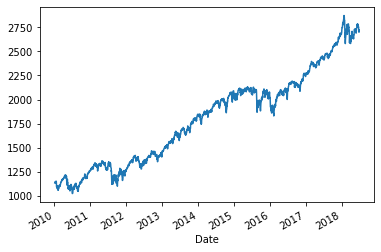

In [79]:
SP500['SP500'].plot()

<AxesSubplot:xlabel='Date'>

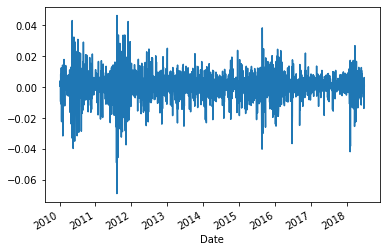

In [80]:
SP500['Returns'].plot()

In [56]:
SP500.loc['2010-01-01':].to_pickle('SP500.pkl')

## VIX Data
Daily Vix Data from 1990s to 2018. All prices. Retrieved from Kaggle

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2013 entries, 2010-01-04 to 2017-12-29
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   VIX     2013 non-null   float64
dtypes: float64(1)
memory usage: 31.5 KB


<AxesSubplot:xlabel='Date'>

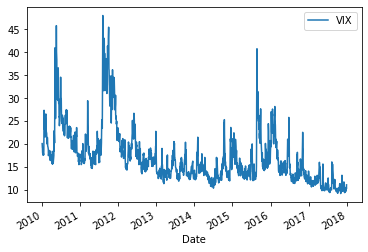

In [57]:
VIX = pd.read_csv("VIX.csv")
VIX["Date"] = pd.to_datetime(VIX["Date"])
VIX.set_index("Date", inplace = True)
VIX = VIX.filter(["Close"])
VIX = VIX.rename(columns = {'Close':'VIX'})
VIX = VIX.loc["2010":"2017"]
VIX.info()
VIX.plot()

In [58]:
VIX.to_pickle('VIX.pkl')

## Option Price Data
We start by importing the data. The dataset will be saved as a pickle file for easier saving and loading after this. The data is currently kept in the same directory, but depending on size may be required to be kept in separate directory.

In [3]:
priceData = np.load('priceData.pkl', allow_pickle = True) # Options written on SPX downloaded from OptionMetrics

In [59]:
priceData = pd.read_csv('pd3.csv')

In [60]:
priceData.head()

,date,exdate,cp_flag,strike_price,impl_volatility,delta,optionid,index_flag,issuer,exercise_style
0,20140102,20140118,C,100000,NaN,NaN,82865684,1,CBOE S&P 500 INDEX,E
1,20140102,20140118,C,1000000,1.206185,0.995579,82865685,1,CBOE S&P 500 INDEX,E
2,20140102,20140118,C,1025000,1.160245,0.995446,82865686,1,CBOE S&P 500 INDEX,E
3,20140102,20140118,C,1050000,1.115371,0.995307,82865687,1,CBOE S&P 500 INDEX,E
4,20140102,20140118,C,1075000,1.071508,0.995161,82865688,1,CBOE S&P 500 INDEX,E


We now convert the data into a cleaner format, removing some of the variables that we don't need such as identifiers and security details. We also set the date as the index, and create a new variable for days to expiry.

In [61]:
priceData = priceData.rename(columns = {'date':'Date', 'exdate':'exDate', 'impl_volatility':'IV','delta':'delta','strike_price':'strike'})
priceData['Date'] = pd.to_datetime(priceData['Date'], format = '%Y%m%d')
priceData['exDate'] = pd.to_datetime(priceData['exDate'], format = '%Y%m%d')
priceData['daysExp'] = priceData['exDate'] - priceData['Date']
priceData['daysExp'] = priceData['daysExp'].dt.days
priceData = priceData.filter(['Date', 'IV', 'delta', 'daysExp', 'strike', 'optionid'])
priceData.set_index('Date', inplace = True)
priceData.strike = priceData.strike / 1000
priceData.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4913410 entries, 2014-01-02 to 2019-12-31
Data columns (total 5 columns):
 #   Column    Dtype  
---  ------    -----  
 0   IV        float64
 1   delta     float64
 2   daysExp   int64  
 3   strike    float64
 4   optionid  int64  
dtypes: float64(3), int64(2)
memory usage: 224.9 MB


Due to the richness of the data, we will simply delete missing data values. These could potentially be imputed but at the moment there is no need, and there may be some interpolation errors that we run into due to the non-linearity of both the delta and implied volatility values.

In [62]:
priceData = priceData[(priceData['IV'].isna() == False) & (priceData['delta'].isna() == False)]
priceData = priceData.sort_values(['optionid', 'daysExp'])
priceData['IVChange'] = priceData.groupby('optionid')['IV'].diff(-1).shift(1)
priceData['DaysChange'] = priceData.groupby('optionid')['daysExp'].diff(1)
priceData = priceData[(priceData['IVChange'].isna() == False)]
#priceData.daysExp = priceData.daysExp.astype('category')



In [33]:
priceData.to_pickle('rawIVChange2.pkl')

Finally we will save the resulting dataset as a pickle and pray that it is small enough to upload to Git.

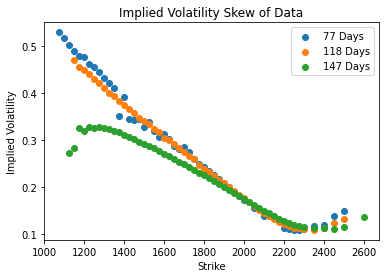

In [35]:
#plt.scatter(priceData.loc['2015-01-02'][priceData.loc['2015-01-02']['daysExp'] == 15].strike,
#            priceData.loc['2015-01-02'][priceData.loc['2015-01-02']['daysExp'] == 15].IV)
plt.scatter(priceData.loc['2015-01-02'][priceData.loc['2015-01-02']['daysExp'] == 88].strike,
            priceData.loc['2015-01-02'][priceData.loc['2015-01-02']['daysExp'] == 88].IV)
plt.scatter(priceData.loc['2015-01-02'][priceData.loc['2015-01-02']['daysExp'] == 118].strike,
            priceData.loc['2015-01-02'][priceData.loc['2015-01-02']['daysExp'] == 118].IV)
plt.scatter(priceData.loc['2015-01-02'][priceData.loc['2015-01-02']['daysExp'] == 168].strike,
            priceData.loc['2015-01-02'][priceData.loc['2015-01-02']['daysExp'] == 168].IV)
plt.legend(['77 Days', '118 Days', '147 Days'])
plt.xlabel('Strike')
plt.ylabel('Implied Volatility')
plt.title('Implied Volatility Skew of Data')
plt.savefig('IVSkew2.png')

In [36]:
priceData.to_pickle('priceData2.pkl')

In [88]:
joinedData = priceData.merge(SP500.loc['2014-01-01':'2018-06-29'],
                              how = 'left', on = 'Date')
joinedData = joinedData[joinedData.SP500.isna() == False]

In [89]:
joinedData.loc[:'2018-12-31']

,IV,delta,daysExp,strike,optionid,IVChange,DaysChange,SP500,Returns
Date,,,,,,,,,
2014-10-10,2.431526,0.995872,71,100.0,81129585,0.357383,5.0,1906.13,-0.011517
2014-10-09,2.741500,0.995188,72,100.0,81129585,-0.309974,1.0,1928.21,-0.020878
2014-10-03,2.387971,0.995460,78,100.0,81129585,0.353529,6.0,1967.90,0.011104
2014-10-02,2.658126,0.994750,79,100.0,81129585,-0.270155,1.0,1946.17,0.000005
2014-10-01,2.551993,0.994950,80,100.0,81129585,0.106133,1.0,1946.16,-0.013337
...,...,...,...,...,...,...,...,...,...
2018-06-29,0.105707,0.008948,38,2950.0,121131971,-0.000418,3.0,2718.37,0.000758
2018-06-29,0.112523,0.007051,38,2975.0,121131972,-0.000333,3.0,2718.37,0.000758
2018-06-29,0.118319,0.005358,38,3000.0,121131973,0.001560,3.0,2718.37,0.000758


In [90]:
joinedData['moneyness'] = joinedData['strike']/joinedData['SP500']

In [92]:
joinData = joinedData.to_pickle('joinData3.pkl')